In [21]:
%matplotlib inline 

import six
import Quandl
import calendar
import numpy as np
import pandas as pd
import pylab as pylab
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import statsmodels.tsa.stattools as stats
from helpers import correlation, procces_stocks, data_manipulation, download_quandl_data

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

import sys
from os import listdir
from os.path import isfile, join

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size

In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')
values_names = ['GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_IBEX', 'INDEX_N225', 'INDEX_SP500']
values_dfs = [GOLD, SILVER, PLAT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD (AM)', 'USD', 'USD AM', 'Close', 'Close', 'Close', 'Close', 'Close']
values = [GOLD['USD (AM)'], SILVER['USD'], PLAT['USD AM'], INDEX_DJIA['Close'], INDEX_HSI['Close'], INDEX_IBEX['Close'], INDEX_N225['Close'], INDEX_SP500['Close']]

In [3]:
def generate_df_dataset(names_list, df_list, cols_list):
    """
    
    """
    if len(names_list) != len(df_list) or len(names_list) != len(cols_list):
        print('The three list must have the same length')
        exit(0)        
    
    rows =  df_list[0].shape[0]
    cols =  len(df_list)
    dates = df_list[0]['Date'].tolist()

    dict_values = {'Date':dates}
    for index in range(len(names_list)):
        name = names_list[index]
        df = df_list[index]
        col = cols_list[index]     

        dict_values[name] = df[col]

    temp_names_list = list(names_list)
    temp_names_list.insert(0, 'Date')
    df_dataset = pd.DataFrame(dict_values)
    df_dataset = df_dataset[temp_names_list]

    return df_dataset

def generate_train_test_array(df_dataset, colsX, colY):
    """
    """
    
    arrayX = np.nan_to_num(df_dataset[colsX].values)
    arrayY = np.nan_to_num(df_dataset[colY].values)
    
    return arrayX, arrayY

In [4]:
GOLD = procces_stocks.difference_between_consecutive_days(GOLD, 'USD (PM)')
SILVER = procces_stocks.difference_between_consecutive_days(SILVER, 'USD')
PLAT = procces_stocks.difference_between_consecutive_days(PLAT, 'USD PM')
INDEX_DJIA = procces_stocks.difference_between_consecutive_days(INDEX_DJIA, 'Close')
INDEX_HSI = procces_stocks.difference_between_consecutive_days(INDEX_HSI, 'Close')
INDEX_IBEX = procces_stocks.difference_between_consecutive_days(INDEX_IBEX, 'Close')
INDEX_N225 = procces_stocks.difference_between_consecutive_days(INDEX_N225, 'Close')
INDEX_SP500 = procces_stocks.difference_between_consecutive_days(INDEX_SP500, 'Close')

In [28]:

values_cols_b = ['DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B']
values_cols = ['DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF']

dataset = generate_df_dataset(values_names, values_dfs, values_cols)
dataset_b = generate_df_dataset(values_names, values_dfs, values_cols_b)

train_df = dataset.head(5000)
test_df = dataset.iloc[5000:]

In [6]:
colsX = ['Date', 'GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_N225', 'INDEX_SP500', 'INDEX_IBEX']
colsY = ['Date', 'INDEX_IBEX']

trainX = np.nan_to_num(train_df.drop(colsY, axis = 1).astype('float32').values).astype('float32')
trainY = np.nan_to_num(train_df.INDEX_IBEX.astype('float32').values).astype('float32')#np.asarray(train_df['INDEX_IBEX'], dtype="float32")
testX = np.nan_to_num(test_df.drop(colsY, axis = 1).astype('float32').values).astype('float32')
testY = np.nan_to_num(test_df.INDEX_IBEX.astype('float32').values).astype('float32')#np.asarray(train_df['INDEX_IBEX'], dtype="float32")

In [29]:
colsX = ['Date', 'GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_N225', 'INDEX_SP500', 'INDEX_IBEX']
colsY = ['Date', 'INDEX_IBEX']
colsToRemove = ['Date', 'INDEX_IBEX']
trainX = np.nan_to_num(train_df.drop(colsToRemove, axis = 1).values)
trainY = np.nan_to_num(train_df['INDEX_IBEX'].values)

In [18]:
print trainX.shape
print trainY.shape
print testX.shape
print testY.shape

(5000, 7)
(5000,)
(740, 7)
(740,)


In [17]:
print testX.reshape(-1, 1).shape

(5180, 1)


In [110]:
#np.any(np.isnan(trainX))
array_bool = np.isfinite(trainX)

for i in range(array_bool.shape[0]):
    for j in range(array_bool.shape[1]):
        if array_bool[i,j] == False:
            print("%s, %s" % (i,j))

In [30]:
scv = svm.SVC(kernel='rbf')
scv.fit(trainX, trainY)
#scv.predict(testX)

ValueError: Unknown label type: array([  0.      ,  14.100098,  -2.      , ..., -24.299805, -28.200195,
       -86.700195])

In [27]:
print scv.score(testX, testY)
print classification_report(testY, scv.predict(testX))
print roc_auc_score(testY, scv.predict(testX))

0.686486486486
             precision    recall  f1-score   support

        0.0       0.65      0.66      0.65       331
        1.0       0.72      0.71      0.71       409

avg / total       0.69      0.69      0.69       740

0.683828363336


In [75]:
## PRICE FLOW BETWEEN TWO CONSECUTIVES DAYS ##

difference_between_consecutive_days(GOLD, 'USD (AM)')
difference_between_consecutive_days(PLAT, 'USD AM')
zeros, ones, date_zeros, date_ones = consecutive_days_tendency(GOLD, 'Diff2')



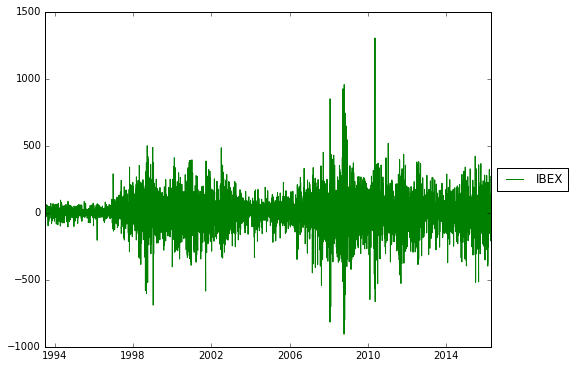

In [84]:




pylab.figure(1)

ax = plt.subplot(111)
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in dataset['Date'].tolist()]
ax.plot(x, dataset['INDEX_IBEX'], 'g', label='IBEX')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
min_date = '1993-04-12'
INDEX_DJIA_new = procces_stocks.select_rows_by_actual_date(INDEX_DJIA, min_date)
INDEX_HSI_new = procces_stocks.select_rows_by_actual_date(INDEX_HSI, min_date)
INDEX_IBEX_new = procces_stocks.select_rows_by_actual_date(INDEX_IBEX, min_date)
INDEX_N225_new = procces_stocks.select_rows_by_actual_date(INDEX_N225, min_date)
INDEX_SP500_new = procces_stocks.select_rows_by_actual_date(INDEX_SP500, min_date)
GOLD_new = procces_stocks.select_rows_by_actual_date(GOLD, min_date)
SILVER_new = procces_stocks.select_rows_by_actual_date(SILVER, min_date)
PLAT_new = procces_stocks.select_rows_by_actual_date(PLAT, min_date)

In [28]:
#data_manipulation.write_csv_data(GOLD_new, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER_new, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT_new, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')